# Will Michigan State Unversity win the next MSU vs UM football game? 

This was my first independent data science project. I earned my BS from Michigan State University and thought it would be fun to try predicting the outcome of our rivalry football game. I also wanted to practice pulling data from different sources and cleaning the data to fit my needs. I'm aware that this is an extremely small dataset and number of features to train a machine learning model with, but this was mostly a fun personal project. I wanted to play around with all of the tools I was learning from MOOCs.

***

## Importing the needed libraries

In [190]:
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

## Import the Past Game Results From Wikipedia

This table from Wikipedia includes the year, where the game was played, the winner, and the score.

In [191]:
R_url = 'https://en.wikipedia.org/wiki/Michigan%E2%80%93Michigan_State_football_rivalry'
R_r = requests.get(R_url)
R_soup = BeautifulSoup(R_r.content, 'lxml')

R_tables = R_soup.find_all("table", attrs = {"class" : "wikitable"})
R_table2 = R_tables[2]
R_table3 = R_tables[3]

R_column_names = [th.getText() for th in 
           R_table2.findAll('tr', limit=2)[0].findAll('th')[1:]]
R_rows = R_table2.findAll('tr')[1:] + R_table3.findAll('tr')[1:]
game_results = [[td.getText() for td in R_rows[i].findAll('td')[1:]] 
                for i in range(len(R_rows) - 2)]

df = pd.DataFrame(game_results, columns = R_column_names)
df = df.rename(columns={'Date': 'Year'})
df.Year = df.Year.astype(int)
df.Winner = df.Winner.apply(lambda x: 'State' if 'State' in x
                                    else 'Tie' if 'Tie' in x else 'Michigan')


In [192]:
df[:5]

,Year,Location,Winner,Score
0,1898,Ann Arbor,Michigan,39–2
1,1902,Ann Arbor,Michigan,119–0
2,1907,Ann Arbor,Michigan,46–0
3,1908,East Lansing,Tie,0–0
4,1910,Ann Arbor,Michigan,6–3


## Import the MSU's Football Coach for Each Year of the Past Years

I also wanted to include the coach for each year, so I needed to find another table that listed the coaches.

In [193]:
C_url = 'https://en.wikipedia.org/wiki/Michigan_State_Spartans_football'
C_r = requests.get(C_url)
C_soup = BeautifulSoup(C_r.content, 'lxml')

C_tables = C_soup.find_all("table", attrs = {"class" : "wikitable"}, limit=2)
C_table = C_tables[0]

C_column_names = [th.getText() for th in 
           C_table.findAll('tr', limit=1)[0].findAll('th')[:2]]
C_rows = C_table.findAll('tr')[2:]
coach = [[td.getText() for td in C_rows[i].findAll('td')[:2]] 
                for i in range(len(C_rows) - 1)]

coach_df = pd.DataFrame(coach, columns = C_column_names)
coach_df.Years = coach_df.Years.apply(lambda x: x.replace('present', '2017'))

In [194]:
coach_df[:5]

,Coach,Years
0,Henry Keep,1897–1898
1,Charles Bemies,1899–1900
2,George Denman,1901–1902
3,Chester Brewer,"1903–1910, 1917, 1919"
4,John Macklin,1911–1915


### Because the table containing the coach information listed the years as a range. I needed to list out each year individually to merge the table of coaches with my first dataframe of results.

In [195]:
listed_years = []
def fix_years(column):  
    for row in column:
        string = str(row)
        endash = '–'
        years = string.split(', ')
        new_list = []
        for year in years:
            if endash in year:
                start, finish = year.split(endash)
                new_list.extend(range(int(start), int(finish) + 1))
            else:
                new_list.append(int(year))
        listed_years.append(str(new_list))
   
fix_years(coach_df.Years)
coach_df['Listed Years'] = listed_years  

In [196]:
coach_df[:5]

,Coach,Years,Listed Years
0,Henry Keep,1897–1898,"[1897, 1898]"
1,Charles Bemies,1899–1900,"[1899, 1900]"
2,George Denman,1901–1902,"[1901, 1902]"
3,Chester Brewer,"1903–1910, 1917, 1919","[1903, 1904, 1905, 1906, 1907, 1908, 1909, 191..."
4,John Macklin,1911–1915,"[1911, 1912, 1913, 1914, 1915]"


### Add a coach column to the features dataframe

In [197]:
coach_dict = coach_df.set_index('Coach')['Listed Years'].to_dict()

def search_dict(dict, search_for):
    for key in dict.keys():
        if search_for in dict[key]:
            return key

df['Coach'] = df.apply(lambda x: search_dict(coach_dict, str(x['Year'])), 
                     axis = 1)

In [198]:
df[:5]

,Year,Location,Winner,Score,Coach
0,1898,Ann Arbor,Michigan,39–2,Henry Keep
1,1902,Ann Arbor,Michigan,119–0,George Denman
2,1907,Ann Arbor,Michigan,46–0,Chester Brewer
3,1908,East Lansing,Tie,0–0,Chester Brewer
4,1910,Ann Arbor,Michigan,6–3,Chester Brewer


### Was it a new coach that year?
I thought it would interesting to see if the outcome of the game had any relationship to whether or not MSU had a new football coach that year.

In [199]:
df['New_Coach'] = df.Coach.ne(df.Coach.shift()).astype(int)

In [200]:
df[:5]

,Year,Location,Winner,Score,Coach,New_Coach
0,1898,Ann Arbor,Michigan,39–2,Henry Keep,1
1,1902,Ann Arbor,Michigan,119–0,George Denman,1
2,1907,Ann Arbor,Michigan,46–0,Chester Brewer,1
3,1908,East Lansing,Tie,0–0,Chester Brewer,0
4,1910,Ann Arbor,Michigan,6–3,Chester Brewer,0


## Import Additional Statistics for Each of the Past Years
I wanted to include more features in my model so I found another website that had some stats from MSU's past football teams. The downside of including more features was that I had to decrease the number of examples. The table that included more stats from MSU's football teams had data for fewer years than my original dataset.

In [201]:
S_url = 'http://www.sports-reference.com/cfb/schools/michigan-state/index.html'
S_r = requests.get(S_url)
S_soup = BeautifulSoup(S_r.content, 'lxml')

S_tables = S_soup.find_all("table", attrs = {"class" : "sortable stats_table"})
S_table = S_tables[0]

S_column_names = [th.getText() for th in 
           S_table.findAll('tr', limit=2)[0].findAll('th')[1:]]
S_rows = S_table.findAll('tr')[:]
stats = [[td.getText() for td in S_rows[i].findAll(['td'])] 
                for i in range(len(S_rows))]

stats_df = pd.DataFrame(stats, columns = S_column_names)

In [202]:
stats_df = stats_df.drop([1])
stats_df = stats_df[stats_df.Year.str.contains("None") == False]
stats_df = stats_df.drop(['Conf', 'Coach(es)', 'Notes'], axis = 1)
stats_df = stats_df.rename(columns={'AP Pre': 'AP_Pre', 'AP High': 'AP_High', 
                                    'AP Post': 'AP_Post'})

stats_df[['AP_Pre', 'AP_High', 'AP_Post']] = stats_df[['AP_Pre', 'AP_High', 
        'AP_Post']].applymap(lambda x: int(x) if x else 0)
stats_df.Bowl = stats_df.Bowl.apply(lambda x: 1 if x else 0)
stats_df = stats_df.apply(pd.to_numeric)

In [203]:
stats_df[:5]

,Year,W,L,T,Pct,SRS,SOS,AP_Pre,AP_High,AP_Post,Bowl
2,2016,3,9,0,0.250,-1.79,4.29,12,8,0,0
3,2015,12,2,0,0.857,15.36,6.58,5,2,6,1
4,2014,11,2,0,0.846,16.07,1.68,8,5,5,1
5,2013,13,1,0,0.929,14.74,0.67,0,3,3,1
6,2012,7,6,0,0.538,6.21,3.75,13,10,0,1


### Merge additional statistics with df

In [204]:
df = df.merge(stats_df, how = 'inner', on = 'Year')

In [205]:
df[:5]

,Year,Location,Winner,Score,Coach,New_Coach,W,L,T,Pct,SRS,SOS,AP_Pre,AP_High,AP_Post,Bowl
0,1918,Ann Arbor,Michigan,21–6,George Gauthier,1,4,3,0,0.571,6.90,3.32,0,0,0,0
1,1925,Ann Arbor,Michigan,39–0,Ralph H. Young,0,3,5,0,0.375,-2.12,-0.12,0,0,0,0
2,1926,Ann Arbor,Michigan,55–3,Ralph H. Young,0,3,4,1,0.438,-5.38,-1.25,0,0,0,0
3,1927,Ann Arbor,Michigan,21–0,Ralph H. Young,0,4,5,0,0.444,-3.59,-1.48,0,0,0,0
4,1928,Ann Arbor,Michigan,3–0,Harry Kipke,1,3,4,1,0.438,-1.56,-1.68,0,0,0,0


Pct: Win-Loss Percentage <br>
SRS: Simple Rating System - a rating that takes into account average point differential and strength of schedule. The rating is denominated in points above/below average, where zero is average. <br>
SOS: Strength of Schedule - a rating of strength of schedule. The rating is denominated in points above/below average, where zero is average. <br>
AP_Pre:  Rank in preseason AP poll <br>
AP_High: Highest rank in AP poll during season <br>
AP_Post: Rank in final AP poll <br>
Bowl: Did MSU attend a bowl game? <br>

## Eliminating some of the features

I wanted to eliminate some of the features because I only have so much information before the 2017 MSU vs UM football game (I wouldn't know MSU's Rank in final AP poll) and because some features were related (SRS and SOS).

In [207]:
df = df.drop(['AP_High', 'AP_Post', 'Bowl', 'SOS'], axis = 1)

In [208]:
df[:5]

,Year,Location,Winner,Score,Coach,New_Coach,W,L,T,Pct,SRS,AP_Pre
0,1918,Ann Arbor,Michigan,21–6,George Gauthier,1,4,3,0,0.571,6.90,0
1,1925,Ann Arbor,Michigan,39–0,Ralph H. Young,0,3,5,0,0.375,-2.12,0
2,1926,Ann Arbor,Michigan,55–3,Ralph H. Young,0,3,4,1,0.438,-5.38,0
3,1927,Ann Arbor,Michigan,21–0,Ralph H. Young,0,4,5,0,0.444,-3.59,0
4,1928,Ann Arbor,Michigan,3–0,Harry Kipke,1,3,4,1,0.438,-1.56,0


## Visualize some of the data using Seaborn

<function matplotlib.pyplot.show>

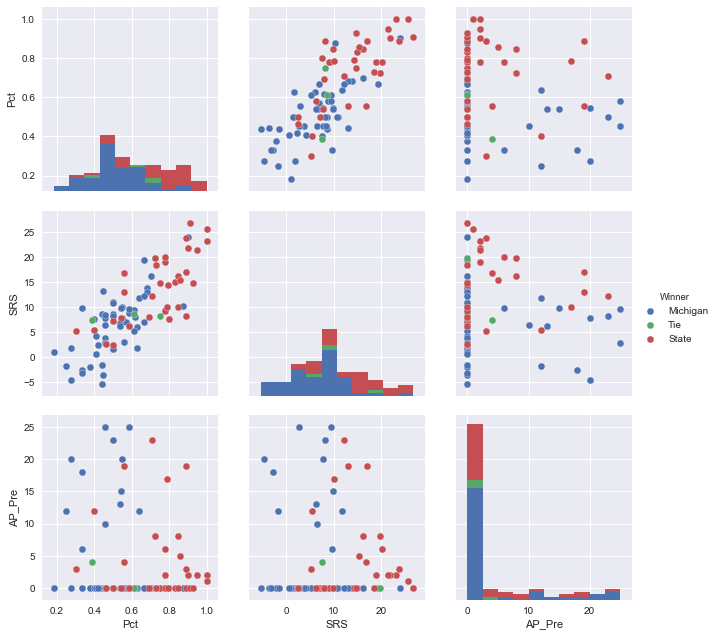

In [209]:
sns_plot1 = sns.pairplot(vars = ['Pct', 'SRS', 'AP_Pre'], data = df, hue = 'Winner', size = 3)
plt.show

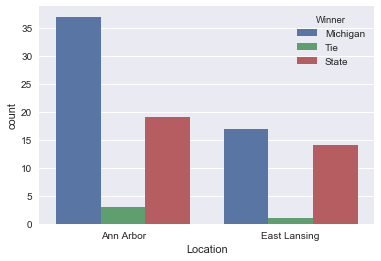

In [211]:
sns_plot2 = sns.countplot(x = "Location", hue = "Winner", data = df)
plt.show()

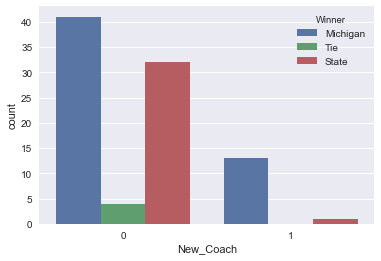

In [212]:
sns_plot3 = sns.countplot(x = "New_Coach", hue = "Winner", data = df)
plt.show()

## I chose to only look at whether or not MSU won (I wanted to change the 3 outcomes -- MSU, UM, or Tie -- to a binary outcome of 1 or 0).

## Encode Categorical Location Data

In [213]:
df.Location = df.Location.apply(lambda x: 1 if 'East Lansing' in x else 0)

In [225]:
df.Winner = df.Winner.apply(lambda x: 1 if 'State' in x else 0)

In [236]:
df[:5]

,Year,Location,Winner,Score,Coach,New_Coach,W,L,T,Pct,SRS,AP_Pre
0,1918,0,0,21–6,George Gauthier,1,4,3,0,0.571,6.90,0
1,1925,0,0,39–0,Ralph H. Young,0,3,5,0,0.375,-2.12,0
2,1926,0,0,55–3,Ralph H. Young,0,3,4,1,0.438,-5.38,0
3,1927,0,0,21–0,Ralph H. Young,0,4,5,0,0.444,-3.59,0
4,1928,0,0,3–0,Harry Kipke,1,3,4,1,0.438,-1.56,0


## Split dataset into training set and test set

In [226]:
X = df[['Location', 'New_Coach', 'Pct', 'SRS', 'AP_Pre',]]
y = df[['Winner']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 6)

In [227]:
y_train[:5]

,Winner
46,0
29,0
32,0
52,1
69,1


## Feature Scaling

In [228]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [217]:
X_train[:5]

array([[ -7.58287544e-01,  -4.34372243e-01,  -5.05651982e-01,
          3.26218533e-01,  -5.61637315e-01],
       [ -7.58287544e-01,  -4.34372243e-01,   1.60367262e+00,
          2.16452013e+00,  -5.61637315e-01],
       [  1.31876095e+00,  -4.34372243e-01,  -1.09098956e+00,
         -1.33356867e-01,  -2.21991033e-03],
       [ -7.58287544e-01,  -4.34372243e-01,   6.91389732e-01,
          1.38560231e+00,  -5.61637315e-01],
       [  1.31876095e+00,   2.30217289e+00,  -2.84172898e-01,
         -1.01422625e-01,  -5.61637315e-01]])

## Random Forest 
To address the possibility of overfitting

In [229]:
randforest = RandomForestClassifier(max_depth = 2, random_state = 6)
randforest.fit(X_train, y_train.values.ravel())
randforest.feature_importances_

array([ 0.07221416,  0.02830255,  0.22081635,  0.50711343,  0.1715535 ])

## Train a Logistic Regression Model

In [230]:
logreg = LogisticRegression(random_state = 6)
logreg.fit(X_train, y_train.values.ravel())
y_pred = logreg.predict(X_test)
logreg_score = accuracy_score(y_test, y_pred)
logreg_class_report = classification_report(y_test, y_pred)
print('Logistic Regression Accuracy Score: ', logreg_score)
print(logreg_class_report)

Logistic Regression Accuracy Score:  0.714285714286
             precision    recall  f1-score   support

          0       0.72      0.81      0.76        16
          1       0.70      0.58      0.64        12

avg / total       0.71      0.71      0.71        28



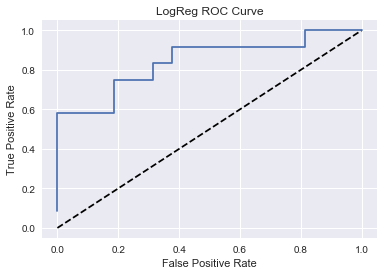

In [231]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogReg ROC Curve')
plt.show()

## Train a K Nearest Neighbor Model

In [232]:
param_grid = {'n_neighbors':np.arange(1,15)}
knn_cv = GridSearchCV(knn, param_grid, cv = 5)
knn_cv.fit(X_train, y_train.values.ravel())
knn_cv.best_params_

{'n_neighbors': 9}

In [233]:
knn_cv.best_score_

0.79365079365079361

In [234]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_train, y_train.values.ravel())
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)
knn_score = knn.score(X_test, y_test)
knn_class_report = classification_report(y_test, y_pred)
print('KNN Accurary Score: ', knn_score)
print(knn_class_report)

KNN Accurary Score:  0.75
             precision    recall  f1-score   support

          0       0.74      0.88      0.80        16
          1       0.78      0.58      0.67        12

avg / total       0.75      0.75      0.74        28



## Train a Support Vector Machine Model 

In [235]:
svc = SVC(kernel = 'linear')
svc.fit(X_train, y_train.values.ravel())
y_pred = svc.predict(X_test)
SVM_score = accuracy_score(y_test, y_pred)
SVM_class_report = classification_report(y_test, y_pred)
print('SVM Accuracy Score: ', SVM_score)
print(SVM_class_report)

SVM Accuracy Score:  0.75
             precision    recall  f1-score   support

          0       0.74      0.88      0.80        16
          1       0.78      0.58      0.67        12

avg / total       0.75      0.75      0.74        28

